 # Map beta of each condition and correlate between groups
 - Mask for amygdala, vmPFC, hippocampus and caudate
    

In [1]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats as sm # for FDR correction
import dask # for paralleliz

In [33]:
#thr = 0.05 # set threshold
def fdr_corr(p, thr=0.05):
    import statsmodels.stats.multitest as sm
    # FDR correction
    # takes the p from the t test, flatten and return a 36x36 mask
    # flatten p
    ptri = np.tril(p)
    pflat = ptri.flatten()
    fdr = sm.multipletests(pflat, alpha=thr, method='fdr_bh')
    fdrArr = fdr[0].reshape(9,9)
    return fdrArr 

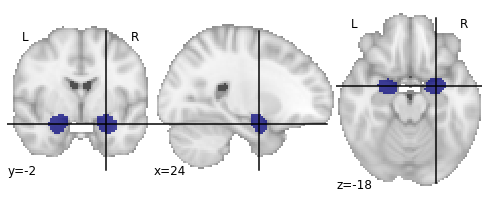

In [3]:
## Amygdala as mask
mask_file = '/media/Data/work/KPE_ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=21", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)


maskerAmg = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                smoothing_fwhm=None, verbose=0).fit()

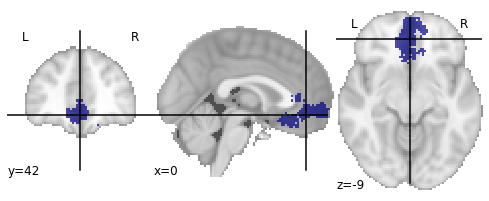

In [4]:
# now lets do the same with vmPFC
mask_file = '/media/Data/work/RCF_or/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=6", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
maskervmPFC = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                             smoothing_fwhm=None,
                                 verbose=0).fit()

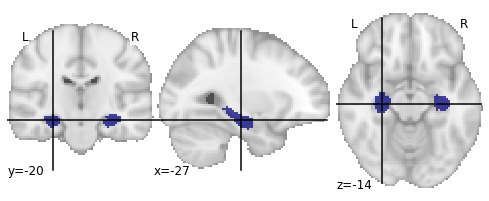

In [5]:
## Run same with hippocampus
## Hippocampus
mask_file = '/media/Data/work/KPE_ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=15", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
maskerHipp = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                            smoothing_fwhm=None,
                                verbose=0).fit()

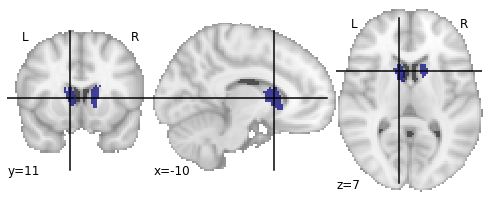

In [6]:
mask_file = '/media/Data/work/caudate_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=12", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
maskerCaudate = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               smoothing_fwhm=None, 
                                                verbose=0).fit()

In [7]:
# compare between groups
import pandas as pd
medication_cond = pd.read_csv('/home/or/kpe_task_analysis/task_based_analysis/kpe_sub_condition.csv')
medication_cond

group_label = np.array(medication_cond.med_cond)
#group_label = list(map(int, group_label))

sub_list = np.array(medication_cond.scr_id)
sub_list

array(['KPE008', 'KPE1223', 'KPE1253', 'KPE1263', 'KPE1293', 'KPE1307',
       'KPE1315', 'KPE1322', 'KPE1339', 'KPE1343', 'KPE1351', 'KPE1356',
       'KPE1364', 'KPE1369', 'KPE1387', 'KPE1390', 'KPE1403', 'KPE1464',
       'KPE1468', 'KPE1480', 'KPE1499'], dtype=object)

In [8]:
subject_list = []
for sub in sub_list:
    sub = sub.split('KPE')[1]
    subject_list.append(sub)
#subject_list.remove('1390')

In [9]:
# function to find ev number (lookin in run.fsf file)
def findEV(txtFile, condition):
    # takes the txtFile and the specific condition
    with open(txtFile) as f:
        datafile = f.readlines()
        lines = []
        for line in datafile:
            if condition in line:
                # found = True # Not necessary
                #print(line)
                lines.append(line)

    return lines[0].split('evtitle')[1].split(')')[0]

def getCorr(sub, condition, masker):
    # takes subject, condition (relax, trauma, sad) and masker object
    fsf_template = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/allScript_ses{ses}_Nosmooth/modelfit_ses_{ses}/_subject_id_{sub}/level1design/run0.fsf'
    betaTemplate = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/allScript_ses{ses}_Nosmooth/modelfit_ses_{ses}/_subject_id_{subject_id}/modelestimate/mapflow/_modelestimate0/results/pe{betaNum}.nii.gz'

    # get beta files for session 1 condition X
    beta1 = fsf_template.format(ses='1', sub=sub)
    number_1 = findEV(beta1, condition)
    # find beta file
    betaFile_1 = betaTemplate.format(ses='1', subject_id = sub, betaNum = number_1)
    beta1_transform = masker.transform(betaFile_1)
    # get beta files for session 2 condition X
    beta2 = fsf_template.format(ses='2', sub=sub)
    number_2 = findEV(beta2, condition)
    # find beta file
    betaFile_2 = betaTemplate.format(ses='2', subject_id = sub, betaNum = number_2)
    beta2_transform = masker.transform(betaFile_2)

    #correlate it
    cor = scipy.stats.pearsonr(beta1_transform[0], beta2_transform[0])[0]
    return cor, beta1_transform, beta2_transform

def generatCor(cond_list, beta1Arr, beta2Arr):
    # this functuion creates a simple matrix of correlation between session 1 and 2
    x = np.zeros([len(cond_list),len(cond_list)])
    for i, cond in enumerate(cond_list):
        
        for j, c in enumerate(cond_list):
            x[i,j] = scipy.stats.pearsonr(beta1Arr[i], beta2Arr[j])[0]
    return x

In [10]:
# get condition list
events_file = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/condition_files/withNumbers/sub-1464_ses-1.csv'
cond = pd.read_csv(events_file, sep='\t')
cond_list = np.unique(cond.trial_type_N)
#cond_list

## Lets try another thing - Using RSA for the same scan. 
- Hypothesis here will say Ketamine will be fatster to recover, hence lower correlation in trauma

In [11]:
cor_OneSes1_amg = []
cor_OneSes1_vmPFC = []
cor_OneSes1_hippo = []
cor_OneSes1_caudate = []
cor_OneSes2_amg = []
cor_OneSes2_vmPFC = []
cor_OneSes2_hippo = []
cor_OneSes2_caudate = []

for i, sub in enumerate(subject_list):
    print (f' Running the {i} subject')
    beta1Arr_amg = []
    beta2Arr_amg = []
    beta1Arr_hipp = []
    beta2Arr_hipp = []
    beta1Arr_vmPFC = []
    beta2Arr_vmPFC = []
    beta1Arr_caudate = []
    beta2Arr_caudate = []
    conditions = []
    for cond in cond_list:
        cor, beta1amg, beta2amg = getCorr(sub, cond, maskerAmg)
        cor, beta1hipp, beta2hipp = getCorr(sub, cond, maskerHipp)
        cor, beta1vmPFC, beta2vmPFC = getCorr(sub, cond, maskervmPFC)
        cor, beta1caudate, beta2caudate = getCorr(sub, cond, maskerCaudate)
        conditions.append(cond)
        beta1Arr_amg.append(beta1amg[0])
        beta2Arr_amg.append(beta2amg[0])
        beta1Arr_hipp.append(beta1hipp[0])
        beta2Arr_hipp.append(beta2hipp[0])
        beta1Arr_vmPFC.append(beta1vmPFC[0])
        beta2Arr_vmPFC.append(beta2vmPFC[0])
        beta1Arr_caudate.append(beta1caudate[0])
        beta2Arr_caudate.append(beta2caudate[0])
    corMat1amg = np.corrcoef(beta1Arr_amg)
    corMat2amg = np.corrcoef(beta2Arr_amg)
    corMat1hipp = np.corrcoef(beta1Arr_hipp)
    corMat2hipp = np.corrcoef(beta2Arr_hipp)
    corMat1vmPFC = np.corrcoef(beta1Arr_vmPFC)
    corMat2vmPFC = np.corrcoef(beta2Arr_vmPFC)
    corMat1caudate = np.corrcoef(beta1Arr_caudate)
    corMat2caudate = np.corrcoef(beta2Arr_caudate)
    cor_OneSes2_amg.append(corMat2amg)
    cor_OneSes1_amg.append(corMat1amg)
    cor_OneSes2_caudate.append(corMat2caudate)
    cor_OneSes1_caudate.append(corMat1caudate)
    cor_OneSes2_hippo.append(corMat2hipp)
    cor_OneSes1_hippo.append(corMat1hipp)
    cor_OneSes2_vmPFC.append(corMat2vmPFC)
    cor_OneSes1_vmPFC.append(corMat1vmPFC)

 Running the 0 subject
 Running the 1 subject
 Running the 2 subject
 Running the 3 subject
 Running the 4 subject
 Running the 5 subject
 Running the 6 subject
 Running the 7 subject
 Running the 8 subject
 Running the 9 subject
 Running the 10 subject
 Running the 11 subject
 Running the 12 subject
 Running the 13 subject
 Running the 14 subject
 Running the 15 subject
 Running the 16 subject
 Running the 17 subject
 Running the 18 subject
 Running the 19 subject
 Running the 20 subject


In [53]:
def plotRSA(arrGroup, cond_list):
    # separate groups
    groupArr = np.array(arrGroup)
    #print('Running t test')
    group1 = groupArr[group_label==1]
    group2 = groupArr[group_label==0]
    # plot mean matrices
    fig, ax_list = plt.subplots(1, 2, figsize=(16,4.5))
    ax = ax_list[0]
    ax.title.set_text('Ketamine')
    sns.heatmap(np.mean(group1, axis=0), cmap='coolwarm', 
                xticklabels = cond_list, yticklabels = cond_list, ax=ax,
               vmin = -1, vmax=1)
    ax = ax_list[1]
    ax.title.set_text('Midazolam')
    sns.heatmap(np.mean(group2, axis=0), cmap='coolwarm', 
                xticklabels = cond_list, yticklabels = cond_list, ax=ax,
               vmin = -1, vmax=1)
    plt.show()


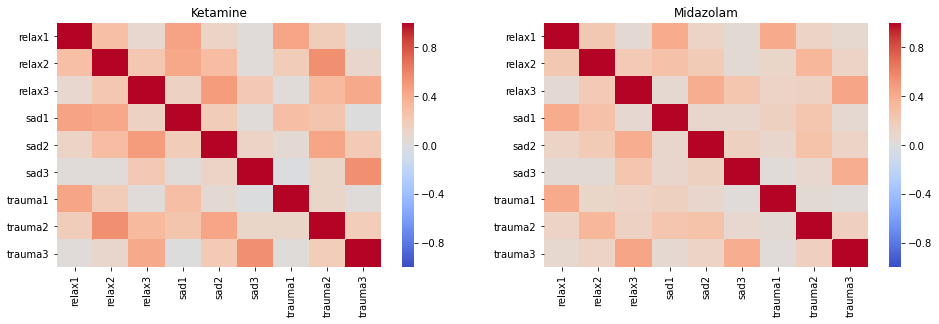

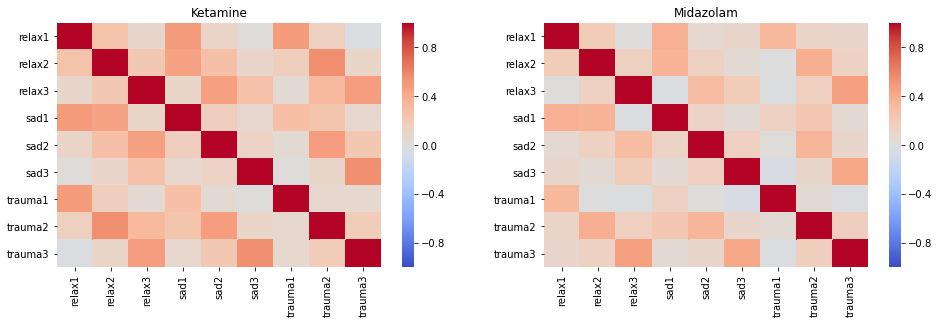

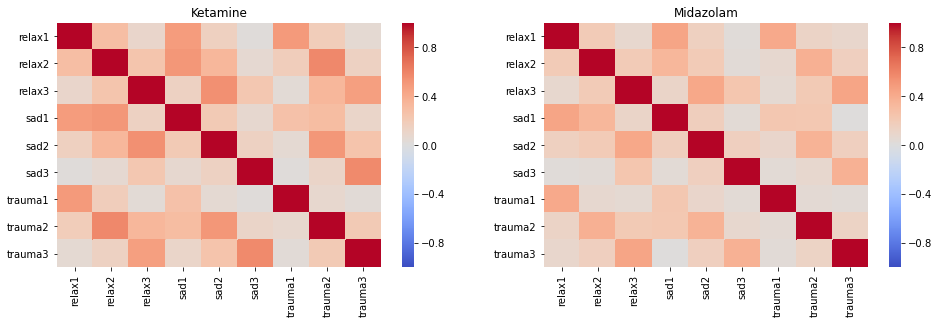

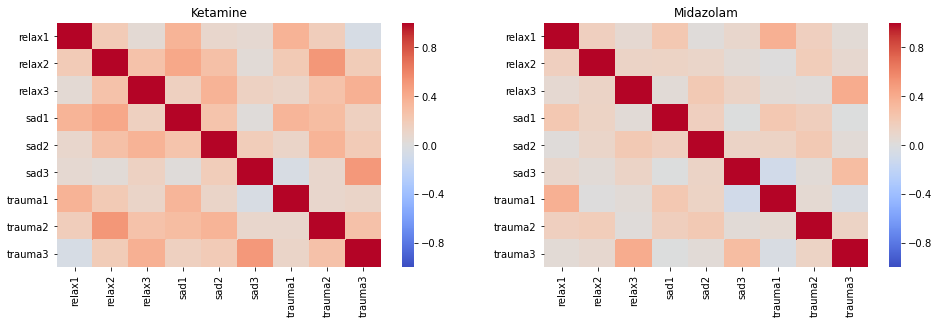

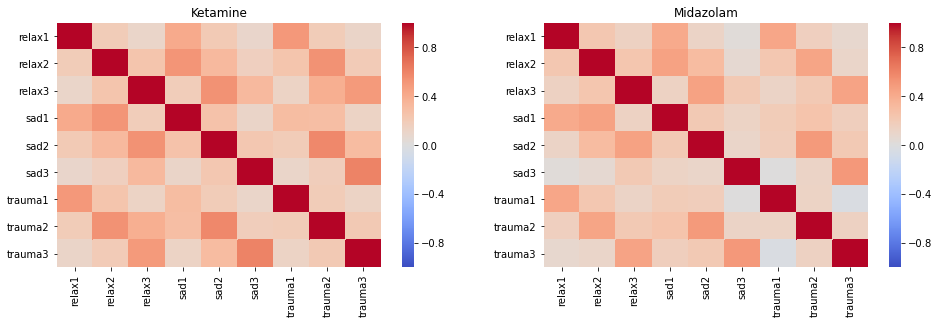

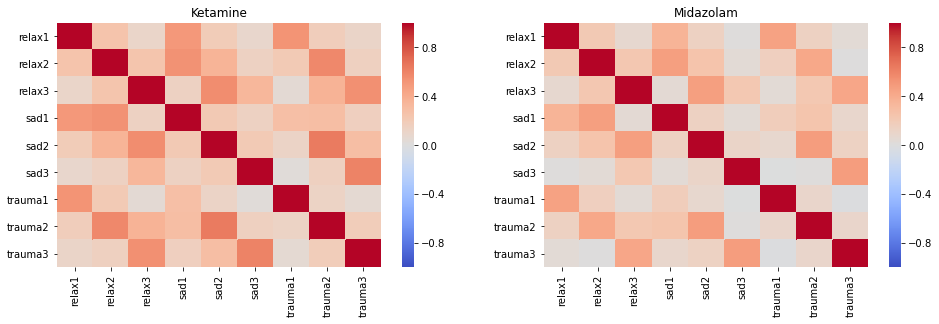

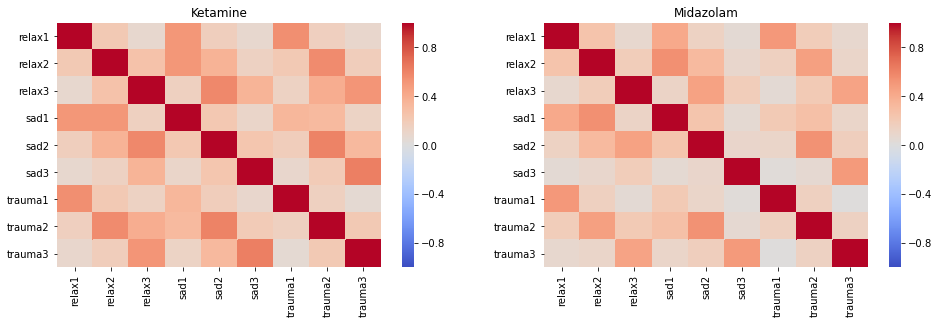

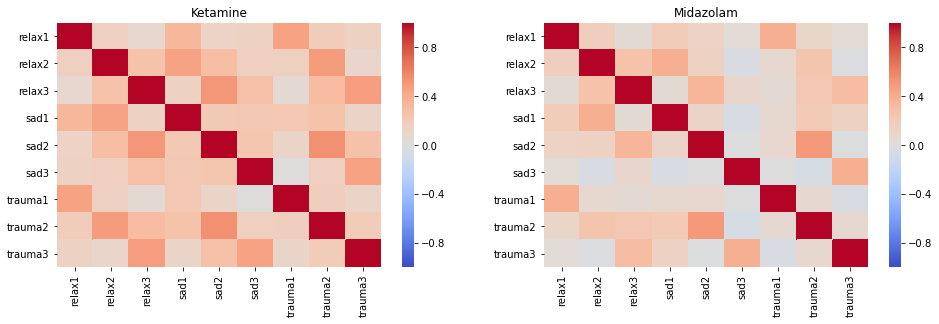

In [54]:
array_list = [cor_OneSes1_amg, cor_OneSes1_caudate, cor_OneSes1_hippo, cor_OneSes1_vmPFC,
             cor_OneSes2_amg, cor_OneSes2_caudate, cor_OneSes2_hippo, cor_OneSes2_vmPFC]
for ar in array_list:
   
    plotRSA(ar, cond_list)

In [55]:
def plotRSAttest(arrGroup, cond_list, thr):
    # separate groups
    groupArr = np.array(arrGroup)
    #print('Running t test')
    group1 = groupArr[group_label==1]
    group2 = groupArr[group_label==0]
    # t test between groups
    t,p = scipy.stats.ttest_ind(group1, group2)
    tArr = np.array(t)
    fdr = fdr_corr(p, thr)
    tArr[~fdr]=0 # set p value to cut

    sns.heatmap(tArr, cmap='coolwarm', 
                xticklabels = cond_list, yticklabels = cond_list,annot=True)#,
               #vmin = -1, vmax=1)
    return t

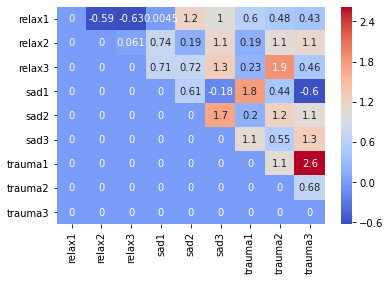

In [56]:
t = plotRSAttest(cor_OneSes2_amg, cond_list, .01)

In [48]:
## build permutation test instead of FDR?
# for each iteration:
# shuffle groups
# run t-test
# end of itreration - compare actual t score of each cell with t-test distribution
# every t-score with chances lower than .05 in random distribution will be considered ok
import random

def permutation(groupArr, group_label, numIter, thr):
    # take groupArr, shuffle group labels and run t test
    # returns a mask of things that crossed significance and a t matrix
    # run the real t test first
    groupArr = np.array(groupArr)
    #print('Running t test')
    group1 = groupArr[group_label==1]
    group2 = groupArr[group_label==0]
    t,p = scipy.stats.ttest_ind(group1, group2)
    permAr = []
    for i in range(numIter):
        
        #print (f'Iteration number {i}')
        group_label_ran = np.array(group_label)
        
        # shuffle groups
        random.shuffle(group_label_ran)
        # stratify to groups
        group1 = groupArr[group_label_ran==1]
        group2 = groupArr[group_label_ran==0]
        tPerm, pPerm = scipy.stats.ttest_ind(group1, group2)
        permAr.append(tPerm)
    permAr = np.array(permAr)
    x = np.empty([9,9])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            check = np.sum(permAr[:,i,j][permAr[:,i,j]>t[i,j]])/ len(permAr)
            if check<=thr:
                x[i,j] = 1
            else:
                x[i,j] = 2
    x = np.array(x, dtype=int) 
    return x , t

In [49]:
x, t = permutation(cor_OneSes1_caudate, group_label, 1000, .05)
halfx = np.tril(x)
t[halfx==2]=0 # using 2 as zero, so I can mask a only lower half

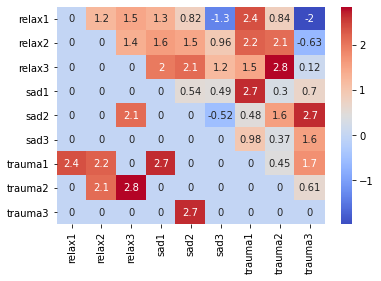

In [50]:
sns.heatmap(t, cmap='coolwarm', 
                xticklabels = cond_list, yticklabels = cond_list,annot=True)